In [1]:
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import pickle
import torch
from dolfin import *
from mshr import *
import matplotlib.tri as tri
import matplotlib.cm as cm
import random
import torch
import time
import datetime
import subprocess
import os
import argparse
import gc
import sys
import pickle
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import diags
from pprint import pprint


import matplotlib.pyplot as plt
from network import *

/home/haltmayermarc/anaconda3/envs/fenics/lib/python3.11/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):


In [2]:
mesh=np.load("/home/haltmayermarc/FEONet_Stokes/FEONet_Stokes_square_copy/data_ordered/P2x1_ne72_stokes_lower_BC.npz", allow_pickle=True)
NUM_ELEMENT, NUM_PTS, p = mesh['ne'], mesh['ng'], mesh['p']
IDX_SOL = mesh['idx_sol']
MATRIX=mesh['matrix']

In [3]:
from scipy.sparse import diags
from scipy.sparse import identity
from scipy.sparse.linalg import onenormest

def spai(A, m):
    """Perform m step of the SPAI iteration."""

    n = A.shape[0]

    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A

    for index in tqdm(range(m)):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G

    return M

In [4]:
precond = np.load("/home/haltmayermarc/FEONet_Stokes/FEONet_Stokes_square_copy/precond_72_lower.npy")

In [5]:
gparams = {}
gparams['file'] = "1000N72"
BATCH_SIZE = 1000

class Dataset(Dataset):
    def __init__(self, gparams, mesh, kind='train'):
        self.pickle_file = gparams['file']
        with open(f'/home/haltmayermarc/FEONet_Stokes/FEONet_Stokes_square_copy/data_ordered/lower/{kind}/' + self.pickle_file + '.pkl', 'rb') as f:
            self.data = pickle.load(f)
        self.load_vector = mesh[f'{kind}_load_vectors']
        self.fenics_u1 = mesh[f'{kind}_fenics_u1']
        self.fenics_u2 = mesh[f'{kind}_fenics_u2']
        self.fenics_p = mesh[f'{kind}_fenics_p']
    def __getitem__(self, idx):
        coeff_u = torch.FloatTensor(self.data[idx,0]).unsqueeze(0)
        f_value = torch.FloatTensor(self.data[idx,1]).unsqueeze(0)
        coeff_f = torch.FloatTensor(self.data[idx,2])
        load_vec_f = torch.FloatTensor(self.load_vector[idx])
        fenics_u1 = torch.FloatTensor(self.fenics_u1[idx])
        fenics_u2 = torch.FloatTensor(self.fenics_u2[idx])
        fenics_p = torch.FloatTensor(self.fenics_p[idx])
        return {'coeff_u': coeff_u, 'f_value': f_value, 'coeff_f': coeff_f, 'load_vec_f' : load_vec_f, 'fenics_u1': fenics_u1, 'fenics_u2': fenics_u2, 'fenics_p': fenics_p}

    def __len__(self):
        return len(self.data)

lg_dataset = Dataset(gparams, mesh, kind='train')
trainloader = DataLoader(lg_dataset, batch_size=BATCH_SIZE, shuffle=True)
lg_dataset = Dataset(gparams, mesh, kind='validate')
validateloader = DataLoader(lg_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
model_FEONet = UNetWithHead(resol_in=64, 
                        in_ch=2,
                        base_ch = 32,
                        latent_ch = 64,
                        d_out = NUM_PTS, 
                        head_filters = 32,
                        head_blocks=4,
                        head_kernel_size=5, 
                        head_padding=(5 - 1)//2)

In [7]:
MATRIX = torch.tensor(mesh['matrix']).to_sparse().float()

In [8]:
def f(x,y,coeff):
        m0, m1, n0, n1, n2, n3=coeff[:,[0]], coeff[:,[1]], coeff[:,[2]], coeff[:,[3]], coeff[:,[4]], coeff[:,[5]]
        return torch.stack([m0*torch.sin(n0*x+n1*y), m1*torch.cos(n2*x+n3*y)],dim=1)

In [9]:
resol_plot=64
grid_x=torch.linspace(-1,1,resol_plot)
plot_grid=torch.cartesian_prod(grid_x,grid_x)

In [10]:
for validate_data in validateloader:
    coeff_u = validate_data['coeff_u']
    coeff_f = validate_data['coeff_f']
    f_value = validate_data['f_value']
    load_vec_f  = validate_data['load_vec_f']
    fenics_u1 = validate_data['fenics_u1']
    fenics_u2 = validate_data['fenics_u2']
    fenics_p = validate_data['fenics_p']

In [11]:
state_dict=torch.load("/home/haltmayermarc/FEONet_Stokes/FEONet_Stokes_square_copy/model/lower/UNetWithHead/model.pt", map_location=torch.device('cpu'), weights_only=False)
#learned_params = torch.load("/home/haltmayermarc/FEONet_Stokes/FEONet-square-with-hole/model_ordered/model.pth", weights_only=False)

In [12]:
model_FEONet.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [13]:
grid_x=torch.linspace(-1,1,64)
input_grid=torch.cartesian_prod(grid_x,grid_x)

In [14]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, axis=-1)/torch.sum((true)**2, axis=-1))**0.5

In [15]:
for validate_data in validateloader:
    coeff_u = validate_data['coeff_u']
    coeff_f = validate_data['coeff_f']
    f_value = validate_data['f_value']
    load_vec_f  = validate_data['load_vec_f']
    fenics_u1 = validate_data['fenics_u1']
    fenics_u2 = validate_data['fenics_u2']
    fenics_p = validate_data['fenics_p']

In [16]:
resol_in = 64
value_f=f(input_grid[:,0],input_grid[:,1], coeff_f).reshape(-1,2,resol_in,resol_in)
pred_coeff_u = model_FEONet(value_f).cpu().detach()

In [17]:
PRECOND = torch.tensor(precond).float()
pred_coeff_u=(PRECOND@pred_coeff_u.transpose(1,2)).transpose(1,2)

In [18]:
sol_u1=fenics_u1
sol_u2=fenics_u2
sol_p=fenics_p

pred_u1=pred_coeff_u[:,0,IDX_SOL[0]]
pred_u2=pred_coeff_u[:,0,IDX_SOL[1]]
pred_p=pred_coeff_u[:,0,IDX_SOL[2]]

In [19]:
total_test_error=rel_L2_error(pred_u1.reshape(1000,-1),sol_u1.reshape(1000,-1).detach().cpu())
print(torch.mean(total_test_error))

total_test_error=rel_L2_error(pred_u2.reshape(1000,-1),sol_u2.reshape(1000,-1).detach().cpu())
print(torch.mean(total_test_error))

total_test_error=rel_L2_error(pred_p.reshape(1000,-1),sol_p.reshape(1000,-1).detach().cpu())
print(torch.mean(total_test_error))

total_test_error=rel_L2_error(pred_coeff_u.reshape(1000,-1),coeff_u.reshape(1000,-1).detach().cpu())
print(torch.mean(total_test_error))

tensor(0.0078)
tensor(0.0294)
tensor(0.0084)
tensor(0.0087)


404


/tmp/ipykernel_3557493/3763893027.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(name='terrain')
/tmp/ipykernel_3557493/3763893027.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(name='terrain')
/tmp/ipykernel_3557493/3763893027.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(name='terrain')
/tmp/ipykernel_3557493/3763893027.py:74: MatplotlibDeprecationWarning: The get_cmap function was dep

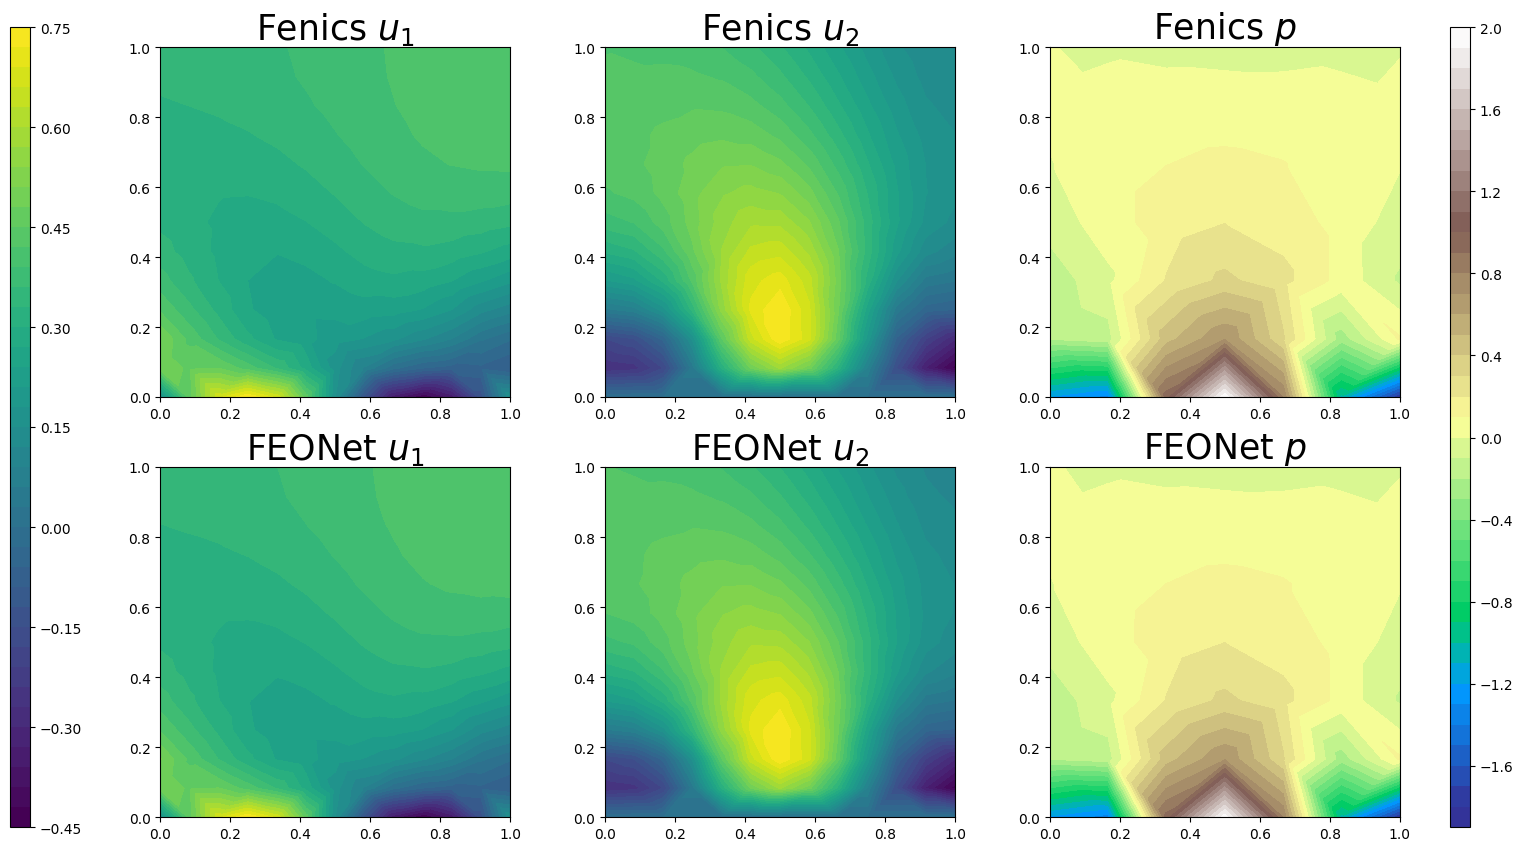

In [20]:
plot_idx=np.random.randint(len(validateloader.dataset))
print(plot_idx)

sol_u1=fenics_u1[plot_idx]
sol_u2=fenics_u2[plot_idx]
sol_p=fenics_p[plot_idx]

mini_u1, maxi_u1 = min(sol_u1), max(sol_u1)
mini_u2, maxi_u2 = min(sol_u2), max(sol_u2)
mini_p, maxi_p = min(sol_p), max(sol_p)

levels_u1 = np.linspace(int(mini_u1)-2, int(maxi_u1)+2, 40)
levels_u2 = np.linspace(int(mini_u2)-2, int(maxi_u2)+2, 40)
levels_p = np.linspace(int(mini_p)-2, int(maxi_p)+2, 40)

pred_u1=pred_coeff_u[:,0,IDX_SOL[0]][plot_idx]
pred_u2=pred_coeff_u[:,0,IDX_SOL[1]][plot_idx]
pred_p=pred_coeff_u[:,0,IDX_SOL[2]][plot_idx]


fig=plt.figure(figsize=(20,10))
cmap = cm.get_cmap(name='terrain')

x=p[torch.tensor(IDX_SOL[0])][:,0]
y=p[torch.tensor(IDX_SOL[0])][:,1]
triang = tri.Triangulation(x, y)
min_radius = 0.001
#triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
#                         y[triang.triangles].mean(axis=1))
#                < min_radius)
cmap = cm.get_cmap(name='terrain')

ax=plt.subplot(2,3,1)
ax.set_title(r'Fenics $u_1$',fontsize=25)
im=ax.tricontourf(triang, sol_u1, vmin=mini_u1, vmax=maxi_u1, cmap="viridis", levels=40)
ax.set_aspect(1)

ax=plt.subplot(2,3,4)
ax.set_title(r'FEONet $u_1$',fontsize=25)
im=ax.tricontourf(triang, pred_u1, vmin=mini_u1, vmax=maxi_u1, cmap="viridis", levels=40)
ax.set_aspect(1)


x=p[torch.tensor(IDX_SOL[1])][:,0]
y=p[torch.tensor(IDX_SOL[1])][:,1]
triang = tri.Triangulation(x, y)
#triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
#                         y[triang.triangles].mean(axis=1))
#                < min_radius)
cmap = cm.get_cmap(name='terrain')

ax=plt.subplot(2,3,2)
ax.set_title(r'Fenics $u_2$',fontsize=25)
im=ax.tricontourf(triang, sol_u2.cpu(), vmin=mini_u2, vmax=maxi_u2, cmap="viridis", levels=40)
ax.set_aspect(1)



ax=plt.subplot(2,3,5)
ax.set_title(r'FEONet $u_2$',fontsize=25)
im=ax.tricontourf(triang, pred_u2, vmin=mini_u2, vmax=maxi_u2, cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(left=0.2)
cbar_ax = fig.add_axes([0.13, 0.10, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax)

x=p[torch.tensor(IDX_SOL[2])][:,0]
y=p[torch.tensor(IDX_SOL[2])][:,1]
triang = tri.Triangulation(x, y)
#triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
#                         y[triang.triangles].mean(axis=1))
#                < min_radius)
cmap = cm.get_cmap(name='terrain')

ax=plt.subplot(2,3,3)
ax.set_title(r'Fenics $p$',fontsize=25)
im=ax.tricontourf(triang, sol_p.cpu(), vmin=mini_p, vmax=maxi_p, cmap='terrain', levels=40)
ax.set_aspect(1)

ax=plt.subplot(2,3,6)
ax.set_title(r'FEONet $p$',fontsize=25)
im=ax.tricontourf(triang, pred_p, vmin=mini_p, vmax=maxi_p, cmap='terrain', levels=40)
ax.set_aspect(1)


fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.10, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax)

## FENICS

In [21]:
num=6
mesh = RectangleMesh(Point(0, 0), Point(1,1), num, num)

V = VectorElement('CG', triangle, 2)
Q = FiniteElement('CG', triangle, 1)
TH = V * Q
W = FunctionSpace(mesh, TH)

SlipRate = Expression ( ( "(3.0 + 1.7 * sin ( 2.0 * pi * x[0] ) )", "0.0" ), degree=3 )
def LowerBoundary ( x, on_boundary ):
    return x[1] < DOLFIN_EPS and on_boundary
bc = DirichletBC(W.sub ( 0 ), SlipRate, LowerBoundary)
bcs = [bc]

( u, p ) = TrialFunctions ( W )
( v, q ) = TestFunctions ( W )
mu = 0.1
a = (mu * inner(grad(v), grad(u)) - p*div(v) - q*div(u) ) * dx

# Assemble matrix
A = assemble(a)
for bc in bcs:
    bc.apply(A)
matrix = A.array()

m0, m1, n0, n1, n2, n3 = coeff_f[plot_idx]

f = Expression(("m0*sin(n0*x[0]+n1*x[1])", "m1*cos(n2*x[0]+n3*x[1])"),
                   degree=5, m0=m0, m1=m1, n0=n0, n1=n1, n2=n2, n3=n3)
l = inner(f, v) * dx
L = assemble(l)
for bc in bcs:
    bc.apply(A, L)

# Solve system in FunctionSpace W
w = Function(W)
solve(A, w.vector(), L)

/home/haltmayermarc/anaconda3/envs/fenics/lib/python3.11/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


1

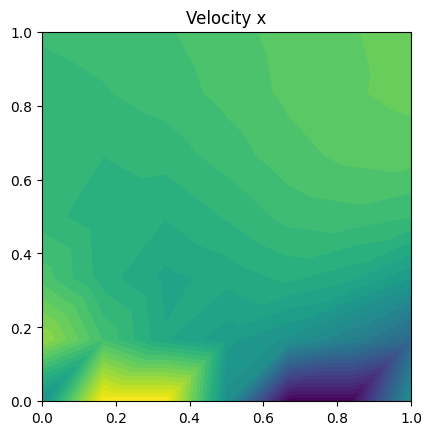

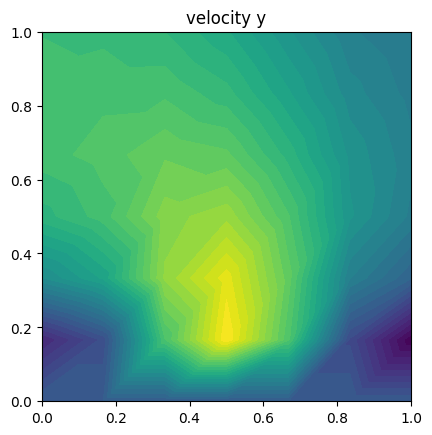

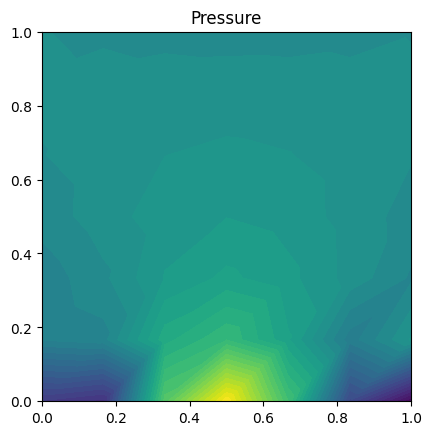

In [22]:
u, p = w.split(deepcopy=True)  # u is the vector Function (velocity), p is scalar (pressure)
u.rename("Velocity", "")
p.rename("Pressure", "")
plot(u.sub(0), title="Velocity x")
plt.figure()
plot(u.sub(1), title="velocity y")
plt.show()
plot(p, title="Pressure")
plt.show()